# Modelling groups with mixtures

## Imports

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale
import seaborn as sns

## Simulation settings

We have two groups of subjects, with different $\beta$ values.

In [2]:
n = 40
group_1_beta_mean = 0.2
group_2_beta_mean = 0.8
sd = 0.05
epsilon = 1

## Distributions of $\beta$ values

Values of $\beta$ are _strongly_ bimodally distributed, and dependent on group identity.

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


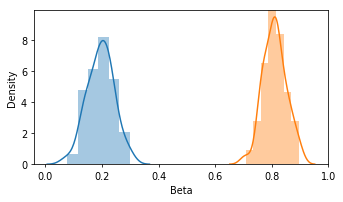

In [3]:
plt.figure(figsize=(5, 3), dpi=70)
group_1_betas = np.random.normal(group_1_beta_mean, sd, n)
group_2_betas = np.random.normal(group_2_beta_mean, sd, n)
sns.distplot(group_1_betas)
sns.distplot(group_2_betas);
plt.xlabel("Beta")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("true_betas.png");

## Create data

Data generated according to a simple linear model with no intercept 

$y = \beta x + \epsilon$

However, $\beta$ values are dependent on group identity. Group A has lower values than group B.

In [4]:
x = np.tile(np.arange(50), n * 2)
y = x.copy()
df = pd.DataFrame(dict(x=x, y=y))
df['level1'] = ['A'] * 50 * n + ['B'] * 50 * n
df['level2'] = np.repeat(np.arange(n * 2), 50)
df['beta'] = np.repeat(np.hstack([group_1_betas, group_2_betas]), 50)
df['y'] = df['x'] * df['beta']
df['y'] += np.random.normal(0, epsilon, len(df))
df[['x', 'y']] = scale(df[['x', 'y']])

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


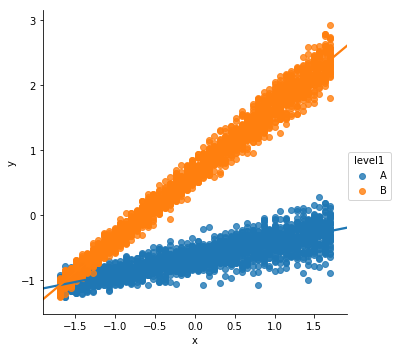

In [5]:
sns.lmplot('x', 'y', hue='level1', data=df);

## Modelling in PyMC3

> **Warning** - the following may be completely nonsensical/incorrect/plain stupid

We assume here that individual subjects' $\beta$ values are drawn from a bimodal distribution, represented as a mixture of Gaussians (in PyMC3, the `NormalMixture` class). We specify here that it's a mixture of 2 Gaussians, as this is what whas used to generate the parameters, and set the prior means at 0.5 for both of them.

For simplicity, we leave the prior SD of the individual-level $\beta$ parameters at 1, rather than also estimating this hierarchically.


In [8]:
with pm.Model() as hierarchical_model:
    
    # Group-level parameters
    mus = pm.Normal('mixture_mus', mu=0.5, sd=0.5, shape=2)
    beta_mu = pm.NormalMixture('beta_mu', [0.5, 0.5], mu=mus, sd=0.5)

    # Individual-level betas - using non-centered reparameterisation
    beta = pm.Normal("beta", mu=beta_mu, sd=1, shape=len(df['level2'].unique()))
    
    # Error
    eps = pm.HalfNormal('eps', 1)

    # Estimated y values
    y_est = beta[df['level2'].values] * df['x']
    
    # Likelihood
    y_like = pm.Normal('likelihood', y_est, sd=eps, observed=df['y'])

In [10]:
with hierarchical_model:
    trace = pm.sample(4000, chains=2, tune=500, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, beta, beta_mu, mixture_mus]
100%|█████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:34<00:00, 129.88it/s]
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\signal\signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\signal\signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


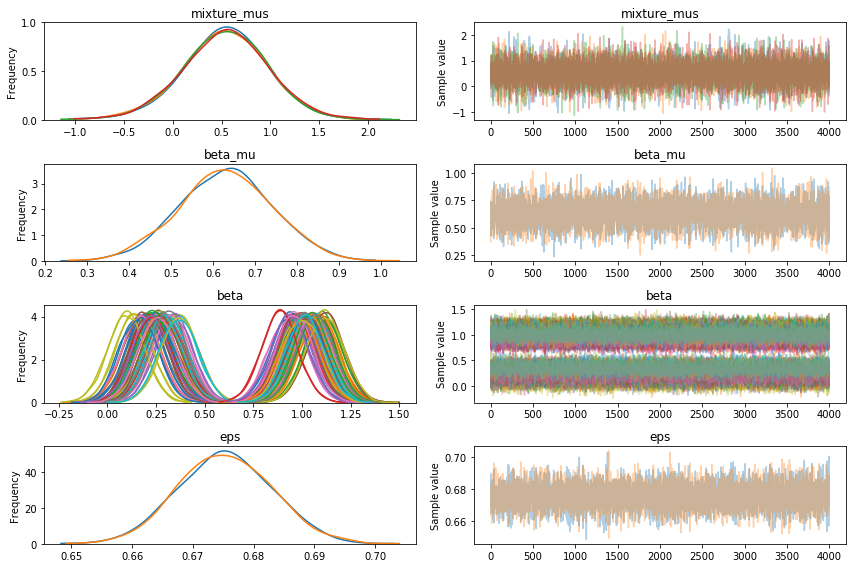

In [11]:
pm.traceplot(trace);
plt.savefig('mixture.png')